In [2]:
from gkan import *
import torch
import random

from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.utils import *

import matplotlib.pyplot as plt
import numpy as np

In [3]:
print('cuda version: {}'.format(torch.version.cuda))
with torch.no_grad():
    torch.cuda.empty_cache()
!nvidia-smi

cuda version: 12.1
Tue Jul  9 10:35:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA TITAN RTX               Off | 00000000:0B:00.0 Off |                  N/A |
| 41%   48C    P2              64W / 280W |   8057MiB / 24576MiB |      5%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cuda:1'

### **Loading Cora Data**

In [5]:
# seed for randomizing the process
path = './temp'
seed = 17

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

transform = T.Compose([T.NormalizeFeatures()])

dataset = Planetoid(path, 'Cora', transform=transform)[0]
dataset = dataset.to(device)

#### **Model params**

In [6]:
hidden_size = 128
grid_size = 20
n_layers = 1
epochs = 20
learning_rate = 0.009
#kan_layer = 'KAN'
kan_layer = 'KAN' # or fourierKAN, fastKAN, KAN. chebKAN is currently the fastest to train
forward_architecture = 1 #1 for aggregate then apply KAN layer, 2 for the opposite
b_spline_order=32

### **Load the Model**

In [7]:
model = GKAN(dataset=dataset, hidden_dim=hidden_size, 
             grid_size=grid_size,
             kan_out_dim=32,
             num_layers=n_layers,
             kan_layer_type=kan_layer,
             use_bias=False,
             aggregation_method=forward_architecture,
             order=b_spline_order
             ).to(device)

### **Train the Model**

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
train_losses = []
train_accuracies = []
validation_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    train_accuracy, train_loss = train(model, optimizer, dataset)
    
    predictions = evaluate(model, dataset)
    
    train_acc = torch.eq(predictions[dataset.train_mask], dataset.y[dataset.train_mask]).float().mean().item()
    val_acc = torch.eq(predictions[dataset.val_mask], dataset.y[dataset.val_mask]).float().mean().item()
    test_acc = torch.eq(predictions[dataset.test_mask], dataset.y[dataset.test_mask]).float().mean().item()
    
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)
    test_accuracies.append(test_acc)
    train_losses.append(train_loss)
    
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f'Epoch: {epoch:04d}, '
              f'Train Loss: {train_loss:.4f}, '
              f'Train Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {val_acc:.4f}, '
              f'Test Accuracy: {test_acc:.4f}')

Epoch: 0000, Train Loss: 1.9457, Train Accuracy: 0.1357, Validation Accuracy: 0.4280, Test Accuracy: 0.4570
Epoch: 0010, Train Loss: 0.6440, Train Accuracy: 0.9857, Validation Accuracy: 0.7360, Test Accuracy: 0.7320
Epoch: 0019, Train Loss: 0.1569, Train Accuracy: 1.0000, Validation Accuracy: 0.7100, Test Accuracy: 0.7200


### **Simple plots**

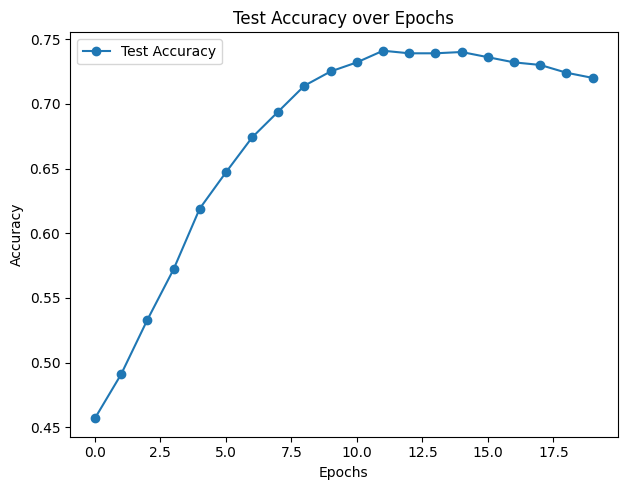

In [9]:
epochs_range = range(epochs)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_accuracies, label='Test Accuracy', marker='o')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
# plt.title('Train Loss over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

plt.tight_layout()
plt.show()